In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, cohen_kappa_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('ndbufes_TaskIV_parsed_combined.csv')

In [3]:
!pip install shap

In [4]:
data.fillna(method='ffill', inplace=True)


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
data

,localization_Tongue,localization_Lip,localization_Floor of mouth,localization_Buccal mucosa,localization_Palate,localization_Gingiva,larger_size,tobacco_use_Yes,tobacco_use_Former,tobacco_use_No,...,sun_exposure_Not informed,gender_M,gender_F,age_group_2,age_group_1,age_group_0,path,TaskIV,folder,label_number
0,1,0,0,0,0,0,2.0,1,0,0,...,0,1,0,1,0,0,0000.png,OSCC,3,2
1,1,0,0,0,0,0,2.0,1,0,0,...,0,1,0,1,0,0,0001.png,OSCC,6,2
2,1,0,0,0,0,0,2.5,1,0,0,...,0,1,0,0,1,0,0002.png,OSCC,3,2
3,1,0,0,0,0,0,2.5,1,0,0,...,0,1,0,0,1,0,0003.png,OSCC,6,2
4,0,1,0,0,0,0,1.5,0,1,0,...,0,0,1,1,0,0,0004.png,OSCC,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,1,0,0,0,0,0,1.2,0,0,1,...,0,1,0,0,0,1,0232.png,Leukoplakia with dysplasia,2,0
233,1,0,0,0,0,0,1.0,0,0,1,...,1,1,0,0,1,0,0233.png,Leukoplakia without dysplasia,2,1
234,1,0,0,0,0,0,1.0,0,0,1,...,1,1,0,0,1,0,0234.png,Leukoplakia without dysplasia,1,1
235,0,0,0,0,1,0,0.7,0,0,1,...,1,1,0,0,1,0,0235.png,Leukoplakia without dysplasia,4,1


In [8]:
class_counts = data['label_number'].value_counts()

# Print the counts of each class
print("Class sample counts:")
print(class_counts)


Class sample counts:
2    91
0    89
1    57
Name: label_number, dtype: int64


In [9]:
X = data.drop(columns=['path', 'TaskIV', 'folder', 'label_number'])
y = data['label_number']


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [13]:
y_pred = model.predict(X_test_scaled)
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.78      0.88        18
           2       0.91      1.00      0.95        21

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



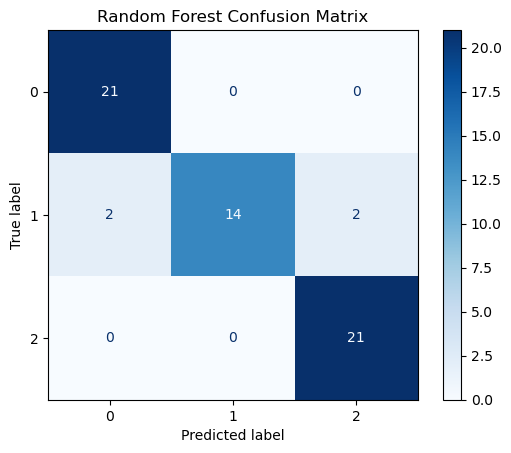

In [14]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('Random Forest Confusion Matrix')
# Save the plot as a high-resolution PNG file
plt.savefig('Confusion Matrix_Random_Forest.png', dpi=300, bbox_inches='tight')
plt.show()

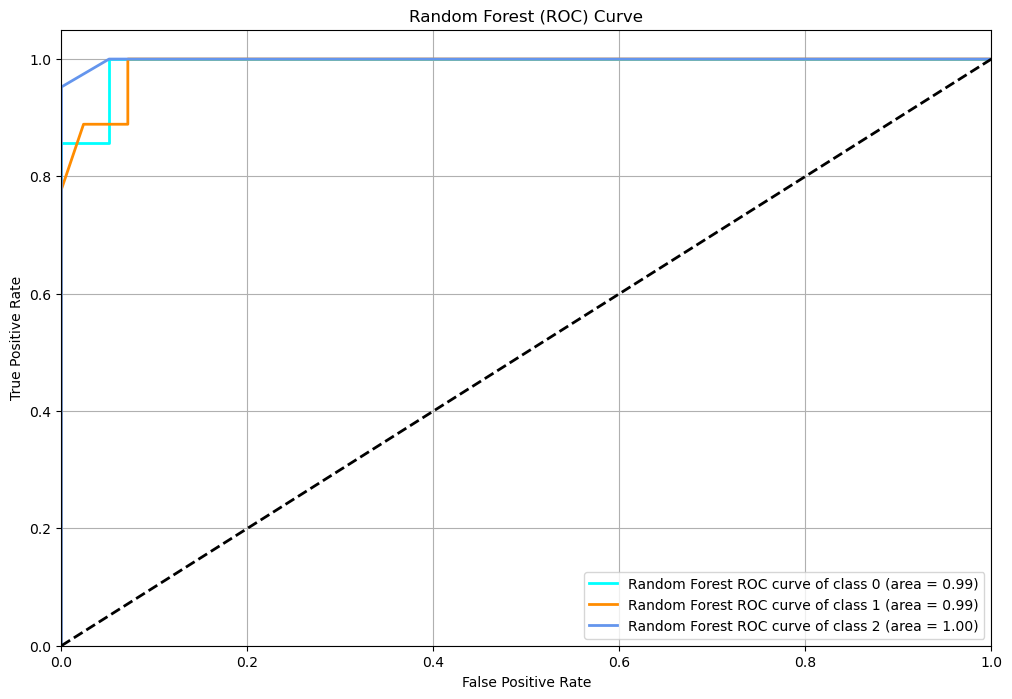

In [15]:
# Calculate ROC AUC and plot ROC curve
y_proba = model.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over all classes
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(model.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Random Forest ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot as a high-resolution PNG file
plt.savefig('Random Forest (ROC) Curve.png', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# Calculate and print Cohen's kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohen\'s Kappa:', kappa)

Cohen's Kappa: 0.8992443324937027


In [17]:
import shap
import numpy as np
# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)

# Verify feature names and SHAP values
print("Feature names:", X.columns)
print("SHAP values shape:", np.array(shap_values).shape)


Feature names: Index(['localization_Tongue', 'localization_Lip',
       'localization_Floor of mouth', 'localization_Buccal mucosa',
       'localization_Palate', 'localization_Gingiva', 'larger_size',
       'tobacco_use_Yes', 'tobacco_use_Former', 'tobacco_use_No',
       'tobacco_use_Not informed', 'alcohol_consumption_No',
       'alcohol_consumption_Former', 'alcohol_consumption_Yes',
       'alcohol_consumption_Not informed', 'sun_exposure_No',
       'sun_exposure_Yes', 'sun_exposure_Not informed', 'gender_M', 'gender_F',
       'age_group_2', 'age_group_1', 'age_group_0'],
      dtype='object')
SHAP values shape: (177, 23, 3)


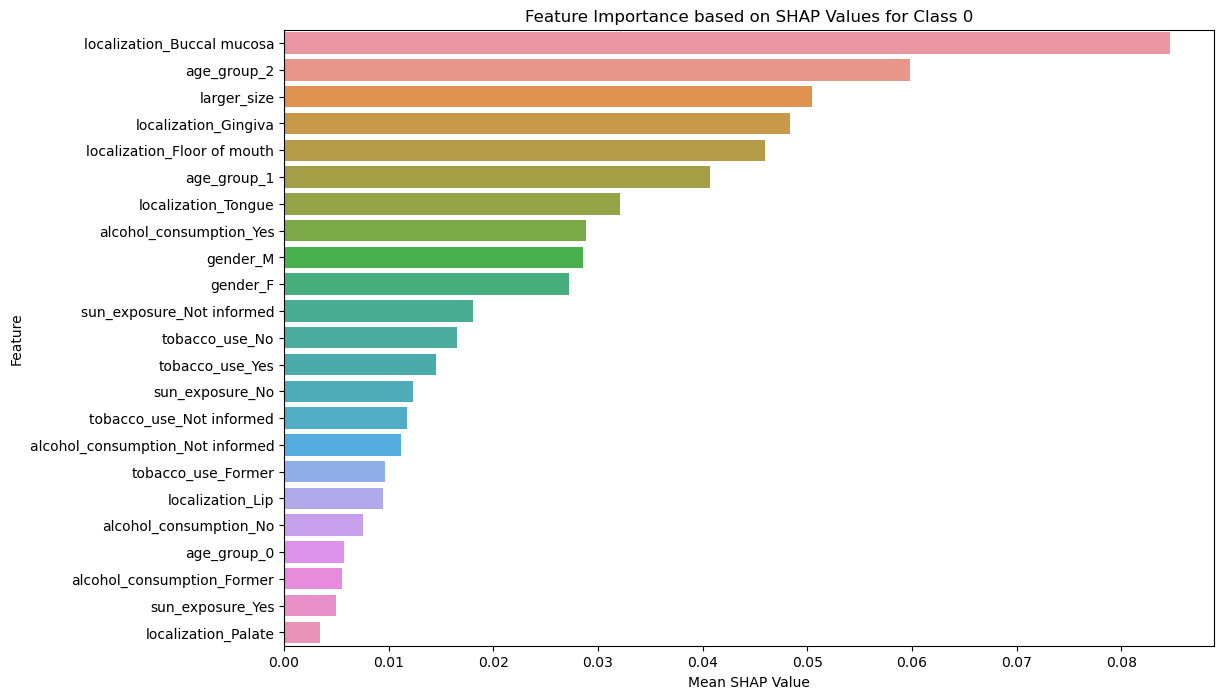

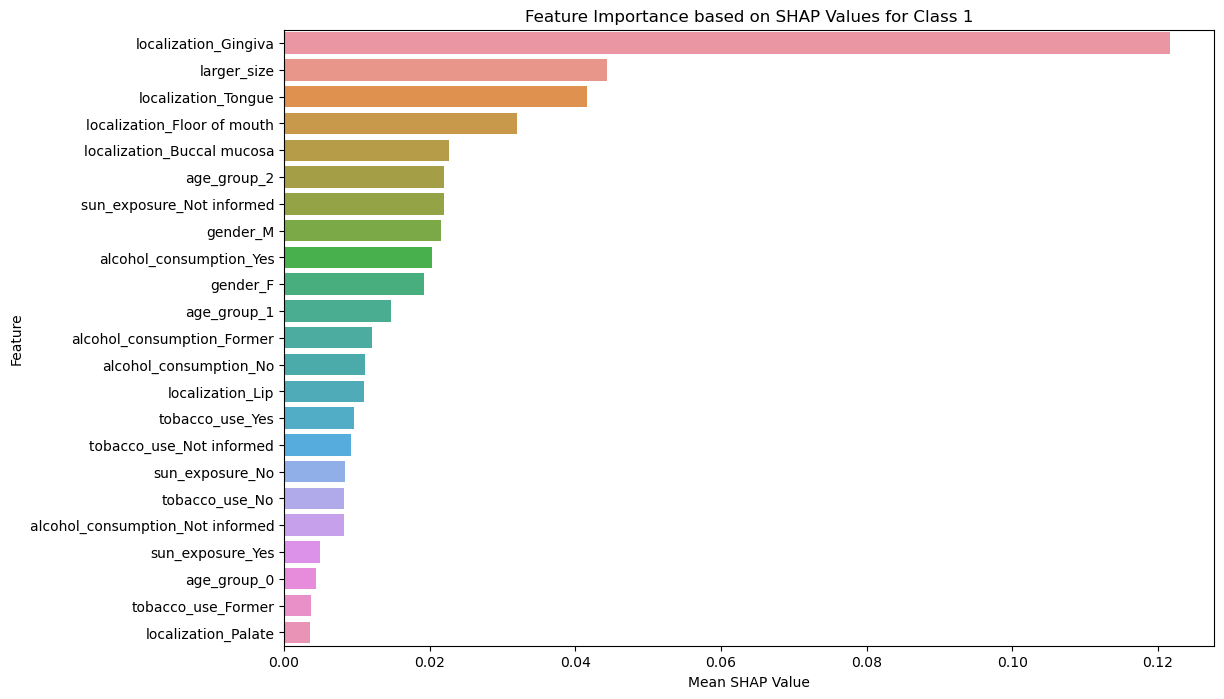

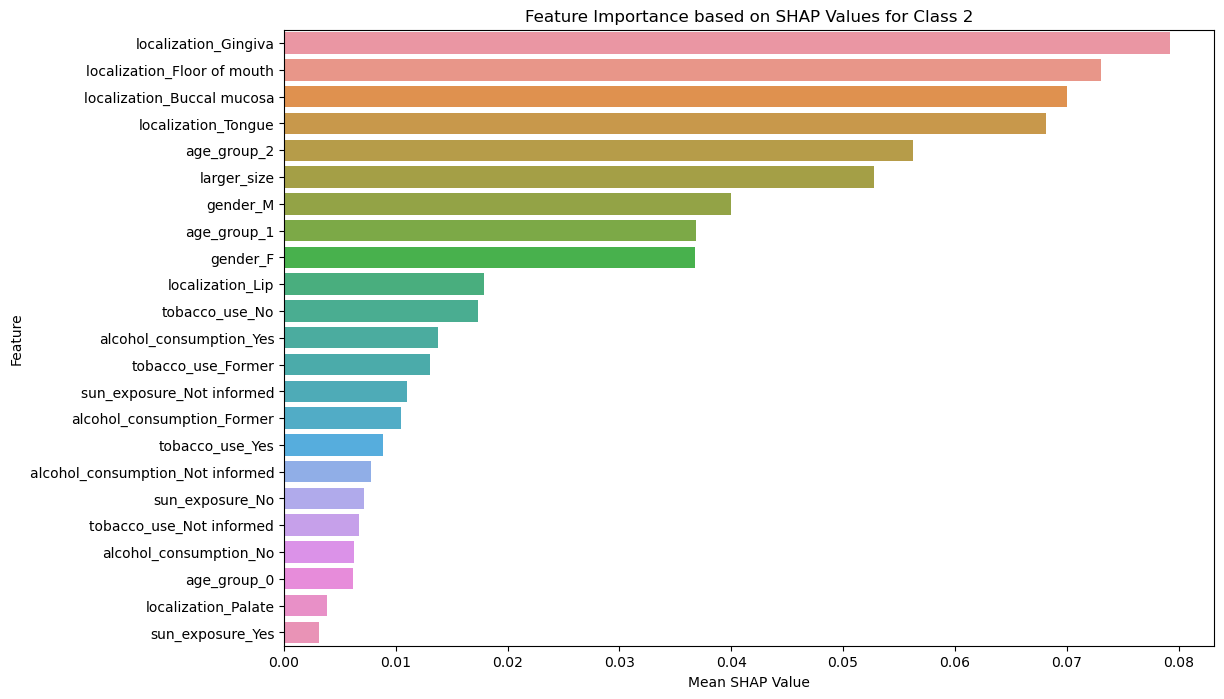

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a list to store mean SHAP values for each class
mean_shap_values_per_class = []

# Loop over each class
for i in range(shap_values.shape[2]):
    # Extract SHAP values for the current class
    shap_values_class = shap_values[:, :, i]
    
    # Compute mean absolute SHAP values for each feature
    mean_shap_values_class = np.abs(shap_values_class).mean(axis=0)
    
    # Create a DataFrame for the current class
    feature_importance_class = pd.DataFrame({
        'Feature': X.columns,
        'Mean SHAP Value': mean_shap_values_class
    }).sort_values(by='Mean SHAP Value', ascending=False)
    
    # Append to list
    mean_shap_values_per_class.append(feature_importance_class)
    
    # Plot bar chart for the current class
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Mean SHAP Value', y='Feature', data=feature_importance_class)
    plt.title(f'Feature Importance based on SHAP Values for Class {i}')
    
    # Save the plot as a high-resolution PNG file
    plt.savefig(f'Feature Importance based on SHAP Values for Class {i}', dpi=300, bbox_inches='tight')
    
    plt.show()


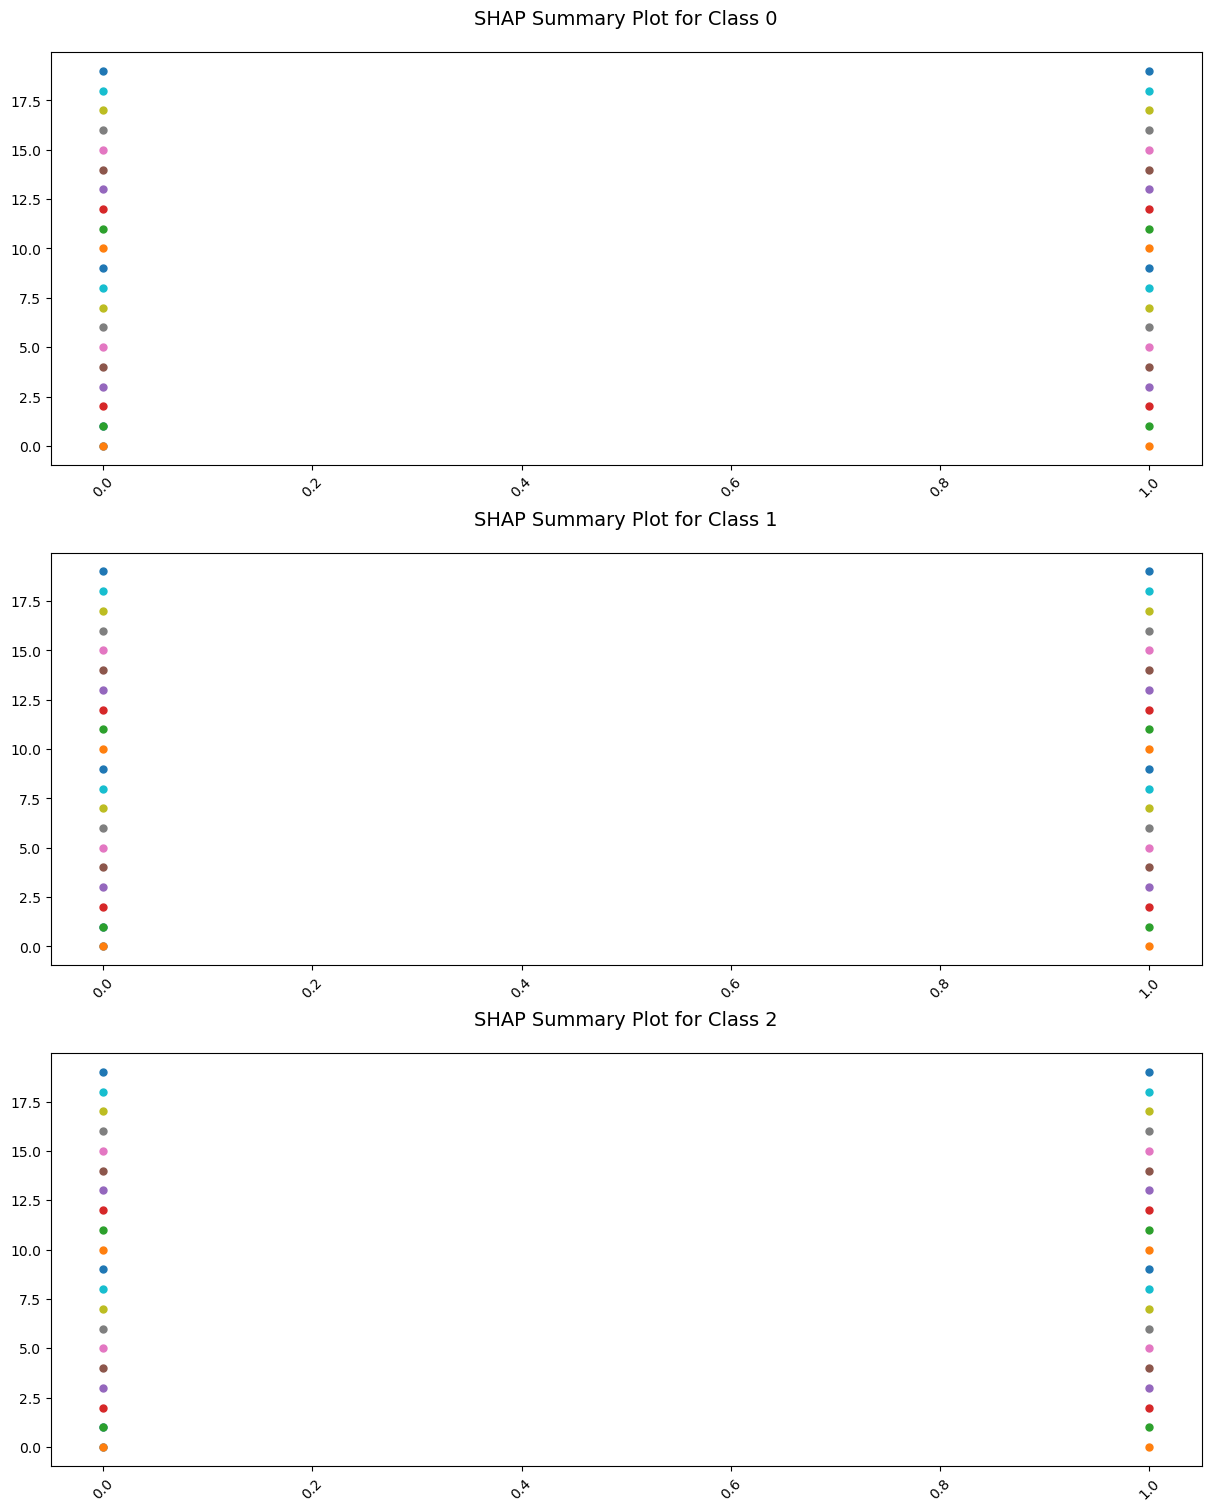

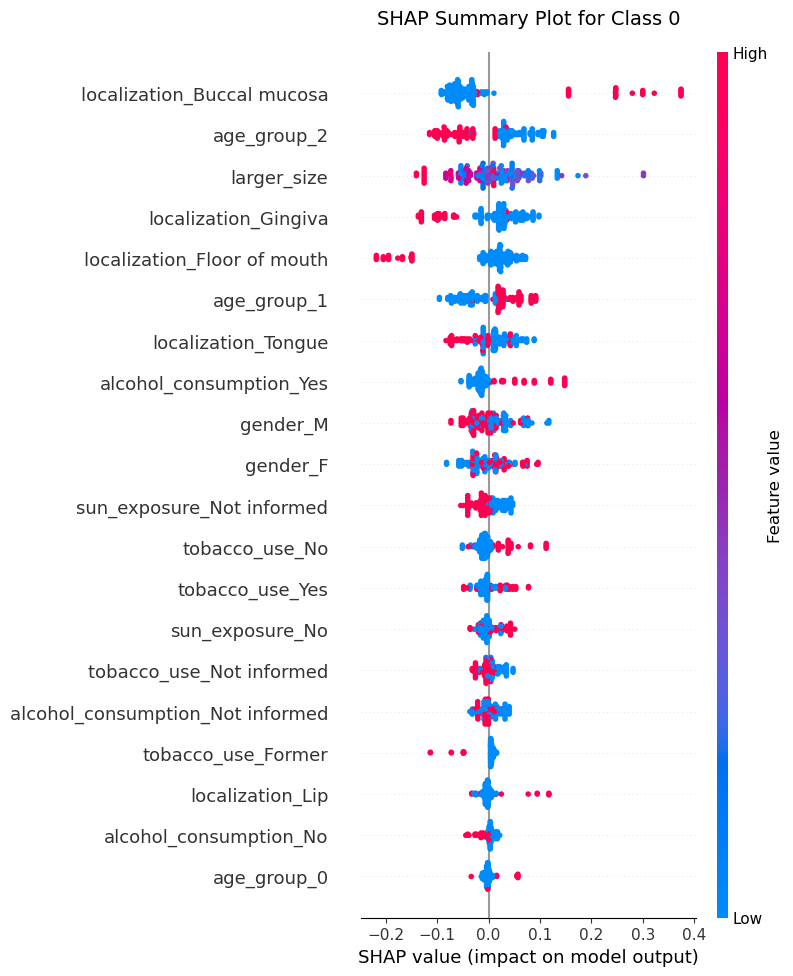

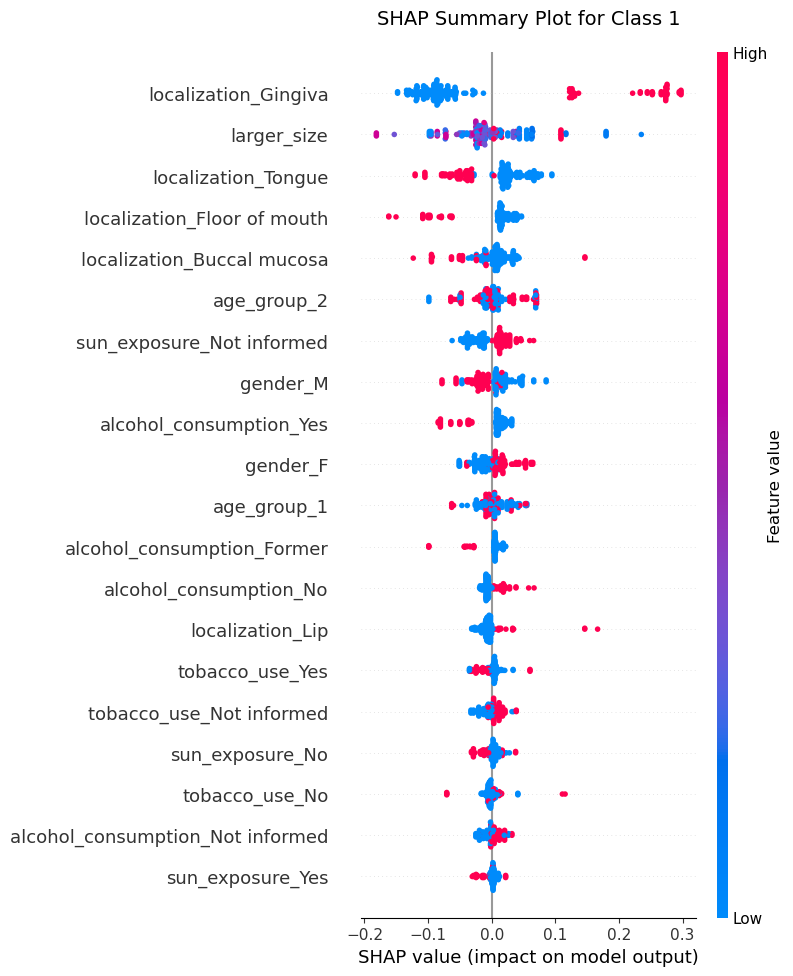

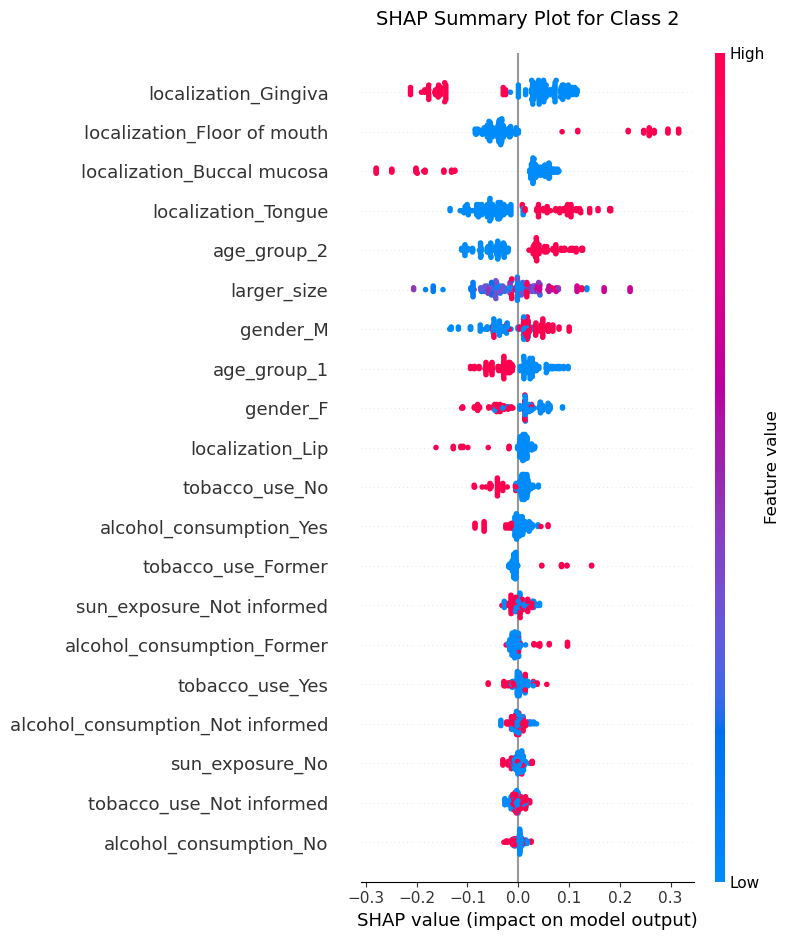

In [19]:
import shap
import matplotlib.pyplot as plt

# Create a new figure
num_classes = shap_values.shape[2]
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(12, 5 * num_classes), constrained_layout=True)

# Flatten axes array for easy iteration if it's 2D
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# Loop over each class to generate SHAP summary plots
for i in range(num_classes):
    # Extract SHAP values for the current class
    shap_values_class = shap_values[:, :, i]
    
    # Create a new figure for each SHAP summary plot
    plt.figure(figsize=(12, 5))
    shap.summary_plot(shap_values_class, X_train, feature_names=X.columns, show=False, plot_type="dot")
    
    # Move the current plot to the corresponding axis
    current_ax = plt.gca()
    axes[i].clear()
    axes[i].set_title(f'SHAP Summary Plot for Class {i}', fontsize=14, pad=20)
    current_ax.set_title(f'SHAP Summary Plot for Class {i}', fontsize=14, pad=20)
    
    # Copy the SHAP plot to the current axis
    for line in current_ax.get_lines():
        axes[i].plot(line.get_xdata(), line.get_ydata(), linestyle='None', marker='o', markersize=5)
    
    # Adjust x and y axis labels
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].tick_params(axis='y', labelsize=10)
    
    # Save the plot as a high-resolution PNG file
    plt.savefig(f'SHAP Summary Plot for Class {i}',dpi=300, bbox_inches='tight')

# Adjust layout to make room for titles and prevent overlap
plt.tight_layout()
plt.show()


SVM Accuracy: 0.8166666666666667
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.86      0.67      0.75        18
           2       0.69      0.95      0.80        21

    accuracy                           0.82        60
   macro avg       0.85      0.81      0.81        60
weighted avg       0.85      0.82      0.82        60

SVM Confusion Matrix:


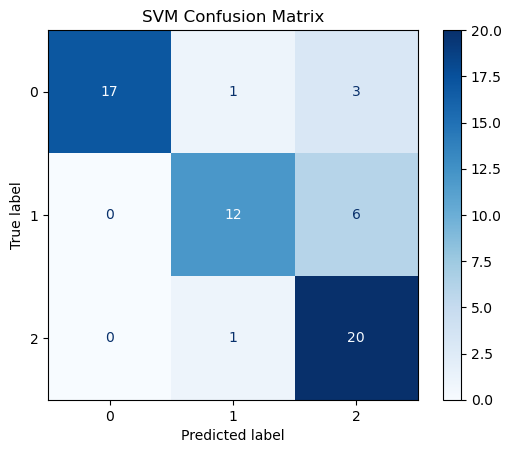

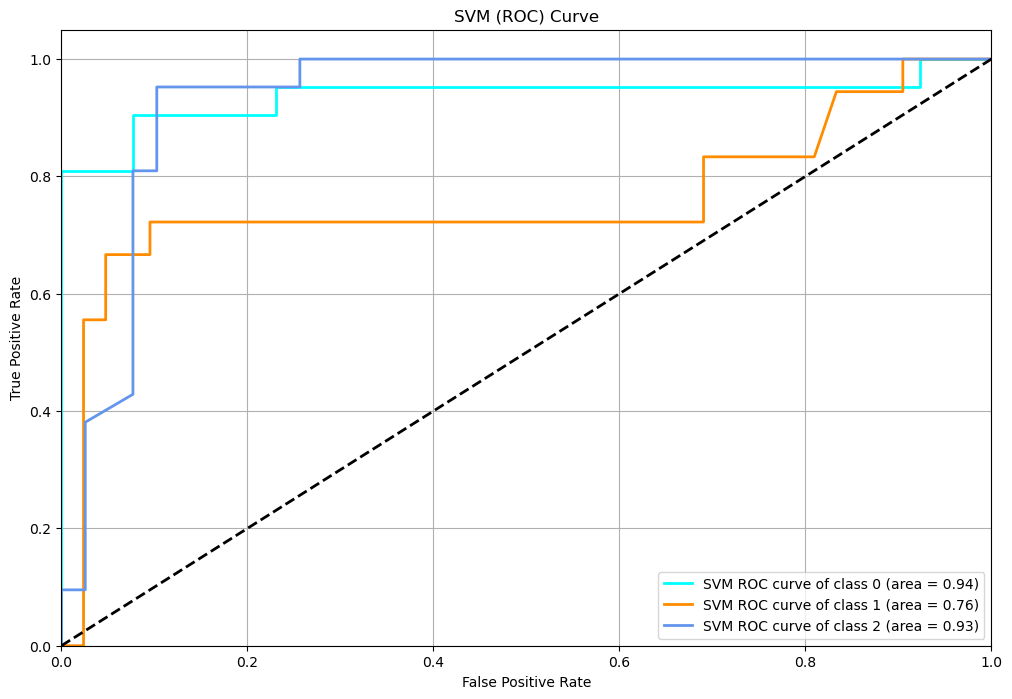

SVM Cohen's Kappa: 0.7229219143576826


In [21]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, cohen_kappa_score

# Train SVM
model1 = SVC(probability=True, random_state=42)
model1.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_test_scaled)

# Evaluate SVM
accuracy = accuracy_score(y_test, y_pred)
print('SVM Accuracy:', accuracy)
print('SVM Classification Report:')
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('SVM Confusion Matrix:')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('SVM Confusion Matrix')

# Save the plot as a high-resolution PNG file
plt.savefig('Confusion Matrix_SVM.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate ROC AUC and plot ROC curve
y_test_proba = model1.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over all classes
for i in range(len(model1.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(model1.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'SVM ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot as a high-resolution PNG file
plt.savefig('SVM (ROC) Curve.png', dpi=300, bbox_inches='tight')

plt.show()

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('SVM Cohen\'s Kappa:', kappa)


KNN Accuracy: 0.7833333333333333
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.75      0.67      0.71        18
           2       0.85      0.81      0.83        21

    accuracy                           0.78        60
   macro avg       0.78      0.78      0.78        60
weighted avg       0.78      0.78      0.78        60

KNN Confusion Matrix:


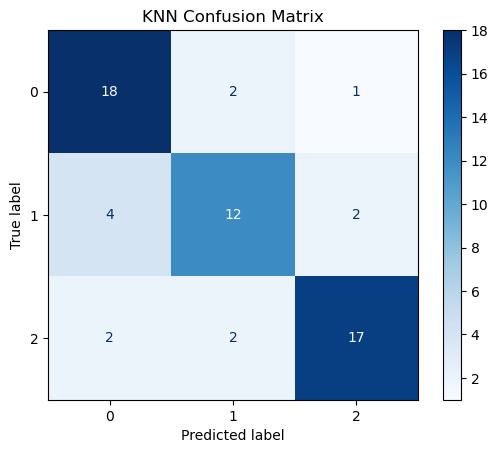

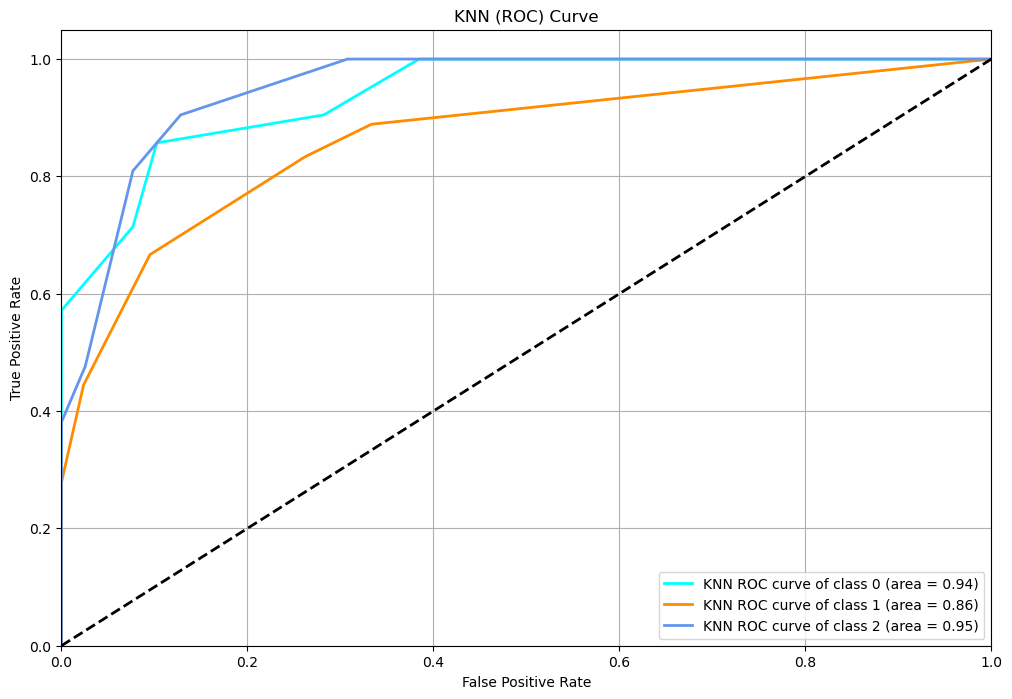

KNN Cohen's Kappa: 0.6733668341708543


In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
model2 = KNeighborsClassifier()
model2.fit(X_train_scaled, y_train)
y_pred = model2.predict(X_test_scaled)

# Evaluate KNN
accuracy = accuracy_score(y_test, y_pred)
print('KNN Accuracy:', accuracy)
print('KNN Classification Report:')
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('KNN Confusion Matrix:')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('KNN Confusion Matrix')

# Save the plot as a high-resolution PNG file
plt.savefig('Confusion Matrix_KNN.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate ROC AUC and plot ROC curve
y_test_proba = model2.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over all classes
for i in range(len(model2.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(model2.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'KNN ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN (ROC) Curve')
plt.legend(loc="lower right")
# Save the plot as a high-resolution PNG file
plt.savefig('KNN (ROC) Curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('KNN Cohen\'s Kappa:', kappa)


Naive Bayes Accuracy: 0.5666666666666667
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58        21
           1       0.43      1.00      0.60        18
           2       0.88      0.33      0.48        21

    accuracy                           0.57        60
   macro avg       0.73      0.59      0.55        60
weighted avg       0.75      0.57      0.55        60

Naive Bayes Confusion Matrix:


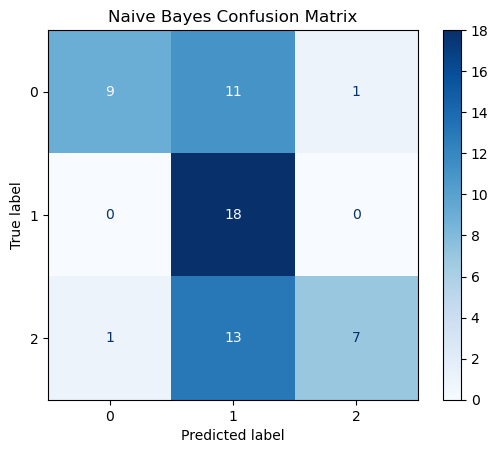

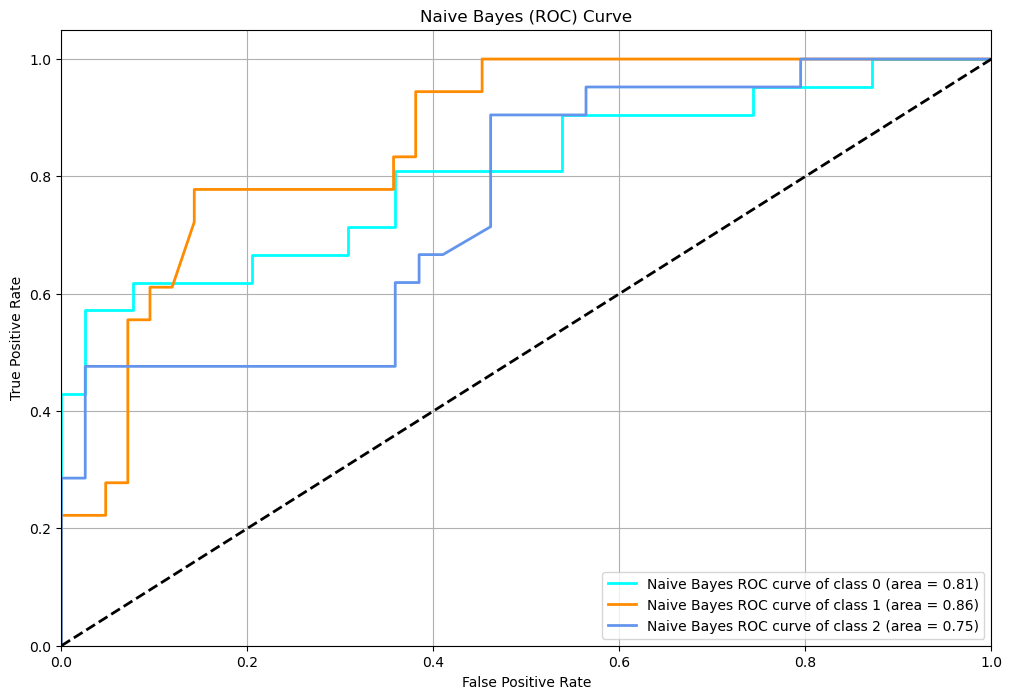

Naive Bayes Cohen's Kappa: 0.3673965936739658


In [23]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes
model3 = GaussianNB()
model3.fit(X_train_scaled, y_train)
y_pred = model3.predict(X_test_scaled)

# Evaluate Naive Bayes
accuracy = accuracy_score(y_test, y_pred)
print('Naive Bayes Accuracy:', accuracy)
print('Naive Bayes Classification Report:')
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Naive Bayes Confusion Matrix:')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('Naive Bayes Confusion Matrix')

# Save the plot as a high-resolution PNG file
plt.savefig('Confusion Matrix_Naive_Bayes.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate ROC AUC and plot ROC curve
y_test_proba = model3.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over all classes
for i in range(len(model3.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(model3.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Naive Bayes ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes (ROC) Curve')
plt.legend(loc="lower right")
# Save the plot as a high-resolution PNG file
plt.savefig('Naive Bayes (ROC) Curve.png', dpi=300, bbox_inches='tight')
plt.show()


# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Naive Bayes Cohen\'s Kappa:', kappa)


Logistic Regression Accuracy: 0.7333333333333333
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        21
           1       0.76      0.72      0.74        18
           2       0.74      0.81      0.77        21

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.73      0.73      0.73        60

Logistic Regression Confusion Matrix:


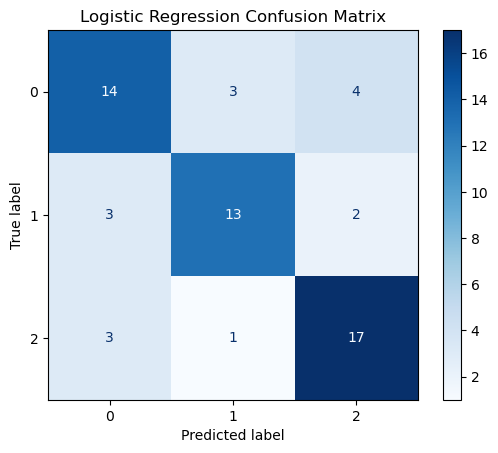

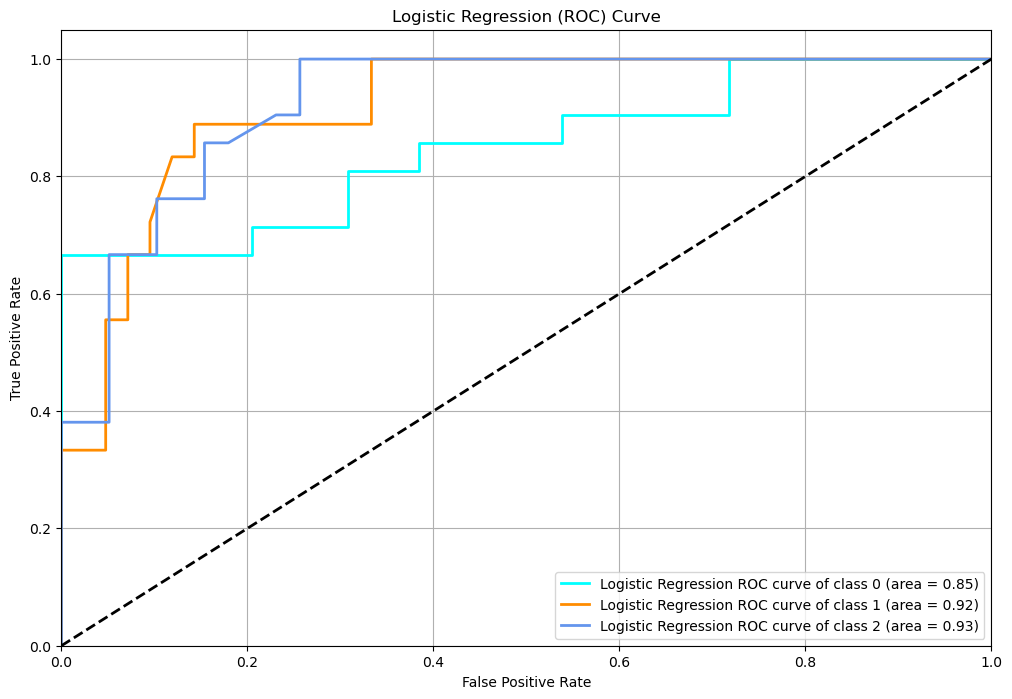

Logistic Regression Cohen's Kappa: 0.5984943538268507


In [24]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
model4 = LogisticRegression(max_iter=1000, random_state=42)
model4.fit(X_train_scaled, y_train)
y_pred = model4.predict(X_test_scaled)

# Evaluate Logistic Regression
accuracy = accuracy_score(y_test, y_pred)
print('Logistic Regression Accuracy:', accuracy)
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Logistic Regression Confusion Matrix:')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('Logistic Regression Confusion Matrix')

# Save the plot as a high-resolution PNG file
plt.savefig('Confusion Matrix_Logistic_Regression.png', dpi=300, bbox_inches='tight')

plt.show()

# Calculate ROC AUC and plot ROC curve
y_test_proba = model4.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over all classes
for i in range(len(model4.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(len(model4.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Logistic Regression ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (ROC) Curve')
plt.legend(loc="lower right")
# Save the plot as a high-resolution PNG file
plt.savefig('Logistic Regression (ROC) Curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Logistic Regression Cohen\'s Kappa:', kappa)
